
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [68]:
#data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing and feature engineering
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

#model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import f1_score

#warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [69]:
#reading in the data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [70]:
#processing 
#categorical dummify
cat_transform = Pipeline([
    ("dummy", OneHotEncoder())
])

#numeric transformer (standardize)
num_transform = Pipeline([
    ("scalar", StandardScaler())
])

#column transformer (apply the dummification and standardization)
ct = ColumnTransformer([
    ('num', num_transform, make_column_selector(dtype_include=np.number)),
    ("cat", cat_transform, make_column_selector(dtype_include=object))
])

#predictors and response
X = ha.drop(columns=['cp'])
y = ha['cp']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [71]:
#pipelines
#knn
pipeline_knn3 = Pipeline(
    [("preprocessor", ct),
     ("kNN", KNeighborsClassifier(n_neighbors=3))]
)

#decision tree1 pipeline
pipeline_tree1 = Pipeline(
    [("preprocessor", ct),
     ("decision", DecisionTreeClassifier(ccp_alpha=0.01))]
)

#lda pipeline
pipeline_lda = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]
)

In [72]:
#fit the models
pipeline_knn3.fit(X_train, y_train)
pipeline_tree1.fit(X_train, y_train)
pipeline_lda.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1547b87d0>),
                                                 ('cat',
                                                  Pipeline(steps=[('dummy',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1547b81d0>)])),
                ('lda', LinearDiscriminantAnalysis())])

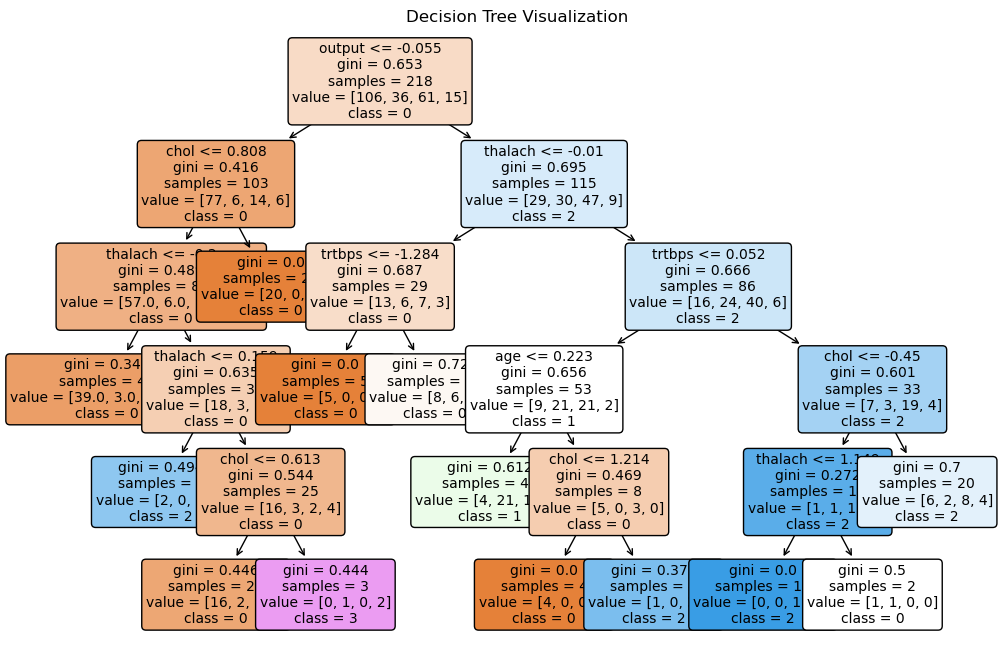

In [73]:
#store
decision_tree = pipeline_tree1.named_steps['decision']

#plot the decision tree
plt.figure(figsize=(12, 8)) 
plot_tree(
    decision_tree, 
    feature_names=X_train.columns,
    class_names=["0", "1", "2", "3"],  # Update to reflect 'cp' categories
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


Root Node (First Split):

Feature Split: chol <= 0.808
Gini Index: 0.653 (indicating moderate impurity at the root node).
Samples: 218 (total dataset samples).
Value: [106, 36, 61, 15] (class distribution at the root node: 106 samples of class 0, 36 of class 1, 61 of class 2, and 15 of class 3).
Class: 0 (majority class at the root node).
Interpretation: The root node splits the dataset based on cholesterol levels (chol). If chol is less than or equal to 0.808, the samples proceed to the left child node. Otherwise, they proceed to the right child node.

Second Split (Left Subtree):

Feature Split: thalach <= -0.01
Gini Index: 0.416 (indicating reduced impurity after the split).
Samples: 103 (samples meeting the condition chol <= 0.808).
Value: [77, 6, 14, 6] (class distribution: 77 of class 0, 6 of class 1, 14 of class 2, and 6 of class 3).
Class: 0 (majority class).
Interpretation: For the left subset of samples where chol <= 0.808, a further split is made based on thalach (maximum heart rate achieved). Samples with thalach <= -0.01 proceed left, while the rest proceed right.

Second Split (Right Subtree):

Feature Split: trtbps <= -1.284
Gini Index: 0.687 (higher impurity than the left child node).
Samples: 115 (samples meeting the condition chol > 0.808).
Value: [29, 30, 47, 9] (class distribution: 29 of class 0, 30 of class 1, 47 of class 2, and 9 of class 3).
Class: 2 (majority class).
Interpretation: For the right subset of samples where chol > 0.808, the split is made based on trtbps (resting blood pressure). Samples with trtbps <= -1.284 proceed left, while the rest proceed right.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [74]:
#create the new columns
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

#create function
def logistic_regression_cv(X, target_column, columns_to_drop):
    """
    Performs logistic regression with cross-validation and prints the mean F1-macro score.

    Parameters:
    - X: DataFrame containing the predictors and target variable.
    - target_column: The target variable for logistic regression.
    - columns_to_drop: List of columns to drop before fitting the model.

    Returns:
    - None
    """
    #predictors and target
    y = X[target_column]
    X_transformed = X.drop(columns=columns_to_drop, axis=1)
    
    #column transformer for preprocessing
    ct = ColumnTransformer(
        [("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
          make_column_selector(dtype_include=object))],
        remainder="passthrough"
    )
    
    #logistic pipeline
    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=100))
    ])
    
    #cross-validation and f1 macro score
    lr_scores = cross_val_score(log_pipeline, X_transformed, y, cv=5, scoring="f1_macro")
    mean_score = lr_scores.mean()
    print(f"Mean F1-macro score for {target_column}: {mean_score:.4f}")

#define targets and columns to drop
cp3_target = "cp_is_3"
cp2_target = "cp_is_2"
cp1_target = "cp_is_1"
cp0_target = "cp_is_0"

cp_drop = ["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0", "cp"]

#call function for each target
logistic_regression_cv(ha, cp3_target, cp_drop)
logistic_regression_cv(ha, cp2_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)
logistic_regression_cv(ha, cp0_target, cp_drop)


Mean F1-macro score for cp_is_3: 0.4800
Mean F1-macro score for cp_is_2: 0.4277
Mean F1-macro score for cp_is_1: 0.4540
Mean F1-macro score for cp_is_3: 0.4800
Mean F1-macro score for cp_is_2: 0.4277
Mean F1-macro score for cp_is_1: 0.4540


Mean F1-macro score for cp_is_0: 0.6579
Mean F1-macro score for cp_is_0: 0.6579


Best at distinguishing cp of 0 (asymptomatic).

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [75]:
#drop columns in previous question
columns_to_drop = ["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"]
ha = ha.drop(columns=columns_to_drop)

#compare category functions
def compare_cp(ha, comparison_value):
    """
    Compares chest pain type 0 with another specified type using logistic regression and computes the mean ROC AUC.

    Parameters:
    - ha: DataFrame containing the dataset.
    - comparison_value: The chest pain type to compare against type 0.

    Returns:
    - Mean ROC AUC score from cross-validation.
    """
    #filter data
    ha_filtered = ha[(ha["cp"] == 0) | (ha["cp"] == comparison_value)]
    
    #predictors and target
    X = ha_filtered.drop("cp", axis=1)
    y = ha_filtered["cp"]
    
    #preprocessing
    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=object))
    ], remainder="passthrough")
    
    #logistic pipeline
    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=100))
    ])
    
    #cross-validation and ROC AUC
    lr_scores = cross_val_score(log_pipeline, X, y, cv=5, scoring="roc_auc")
    return lr_scores.mean()

#compare with other categories
roc_auc_cp0_vs_1 = compare_cp(ha, 1)
roc_auc_cp0_vs_2 = compare_cp(ha, 2)
roc_auc_cp0_vs_3 = compare_cp(ha, 3)

#print
print(f"ROC AUC (cp=0 vs cp=1): {roc_auc_cp0_vs_1:.4f}")
print(f"ROC AUC (cp=0 vs cp=2): {roc_auc_cp0_vs_2:.4f}")
print(f"ROC AUC (cp=0 vs cp=3): {roc_auc_cp0_vs_3:.4f}")


ROC AUC (cp=0 vs cp=1): 0.7885
ROC AUC (cp=0 vs cp=2): 0.7083
ROC AUC (cp=0 vs cp=3): 0.7333
ROC AUC (cp=0 vs cp=1): 0.7885
ROC AUC (cp=0 vs cp=2): 0.7083
ROC AUC (cp=0 vs cp=3): 0.7333


Best at distinguishing between cp 0 and cp 1.